In [199]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [200]:
def rotateY(point, theta):
    R = np.array([[ np.cos(theta), 0, np.sin(theta)],
                  [ 0,             1,             0],
                  [-np.sin(theta), 0, np.cos(theta)]])
    return R @ point

def rotateZ(point, theta):
    R = np.array([[ np.cos(theta), np.sin(theta), 0],
                  [-np.sin(theta), np.cos(theta), 0],
                  [ 0,             0,             1]])
    return R @ point

def starfish_ee(alpha):
    if not type(alpha) is list:
        alpha = alpha*np.ones(5)
        
    return np.array([rotateZ(rotateY([1,0,0], alpha[i]), -2*np.pi*i/5) for i in range(5)])

def draw_hand(ax, world_landmarks, lines, ee_idx, elev=0, azim=-90):
    
    for line in lines:
        x = [world_landmarks[p,0] for p in line]
        y = [-world_landmarks[p,1] for p in line]
        z = [-world_landmarks[p,2] for p in line]
        ax.plot(x, y, z, 'b')
        
    # ax.scatter(world_landmarks[:,0], -world_landmarks[:,1], -world_landmarks[:,2])
    ax.scatter(world_landmarks[ee_idx,0], -world_landmarks[ee_idx,1], -world_landmarks[ee_idx,2], color='r', marker='x')
    ax.plot([0,0.1],[0,0],[0.1,0.1],'b')
    ax.plot([0,0],[0,0.1],[0.1,0.1],'g')
    ax.plot([0,0],[0,0],[0.1,0],'r')
    ax.set_xlabel('x [m]')
    ax.view_init(elev=elev, azim=azim)

def draw_starfish(ax, alpha, ee_idx):
    if not type(alpha) is list:
        alpha = alpha*np.ones(5)
        
    s_ee = starfish_ee(alpha)* 0.1;
    for ee in s_ee:
        ax.plot([0, ee[0]], [0, ee[1]], [0, ee[2]], 'r')
        
    ax.scatter(s_ee[ee_idx,0], s_ee[ee_idx,1], s_ee[ee_idx,2], color='r', marker='x')

In [201]:
LINES_HAND = [[0,1],[1,2],[2,3],[3,4], 
            [0,5],[5,6],[6,7],[7,8],
            [5,9],[9,10],[10,11],[11,12],
            [9,13],[13,14],[14,15],[15,16],
            [13,17],[17,18],[18,19],[19,20],[0,17]]

# world_landmarks = np.array([[0.02374268,  0.08691406,  0.00775146], # flat hand
#  [ 0.04437256,  0.05322266,  0.0010376 ],
#  [ 0.05435181,  0.02783203, -0.00985718],
#  [ 0.06225586, -0.00268555, -0.02325439],
#  [ 0.06652832, -0.02709961, -0.02154541],
#  [ 0.02354431, -0.01275635,  0.0012207 ],
#  [ 0.01716614, -0.03955078, -0.00231934],
#  [ 0.01314545, -0.05871582, -0.01324463],
#  [ 0.01177216, -0.07482910, -0.04034424],
#  [ 0.00268555, -0.00598145,  0.00209045],
#  [-0.00336647, -0.03674316, -0.00219727],
#  [-0.00463867, -0.06225586, -0.02017212],
#  [-0.00500488, -0.07977295, -0.04547119],
#  [-0.01699829,  0.00622559, -0.00180054],
#  [-0.02333069, -0.02276611, -0.00952148],
#  [-0.02537537, -0.04528809, -0.02410889],
#  [-0.02499390, -0.06634521, -0.04180908],
#  [-0.02635193,  0.02539062, -0.01043701],
#  [-0.04098511,  0.00578308, -0.01611328],
#  [-0.04727173, -0.01223755, -0.02810669],
#  [-0.04705811, -0.02474976, -0.0435791 ]])

world_landmarks = np.array([[-0.00744629,  0.07958984,  0.05474854], # closed (not fully)
 [ 0.02064514,  0.05786133,  0.03277588],
 [ 0.03594971,  0.04211426,  0.00765991],
 [ 0.04766846,  0.02563477, -0.02746582],
 [ 0.05764771,  0.00891113, -0.04669189],
 [ 0.02729797, -0.00531006, -0.00030518],
 [ 0.03117371, -0.03002930, -0.01303101],
 [ 0.03353882, -0.04699707, -0.02761841],
 [ 0.03613281, -0.05847168, -0.05865479],
 [ 0.00489807, -0.00646973,  0.0       ],
 [ 0.00433731, -0.03796387, -0.00582886],
 [ 0.00579834, -0.06115723, -0.02328491],
 [ 0.01037598, -0.07806396, -0.05487061],
 [-0.01730347,  0.00210571,  0.00053406],
 [-0.02194214, -0.02532959, -0.01220703],
 [-0.02136230, -0.04602051, -0.03497314],
 [-0.01646423, -0.06414795, -0.06213379],
 [-0.03524780,  0.02026367, -0.00073242],
 [-0.04708862,  0.00370789, -0.01138306],
 [-0.05065918, -0.00814819, -0.03103638],
 [-0.04772949, -0.01484680, -0.05511475]])

effectors = [point for (point,_) in LINES_HAND]
h_ee_idx = []
for line in LINES_HAND:
    if not line[1] in effectors:
        h_ee_idx.append(line[1])

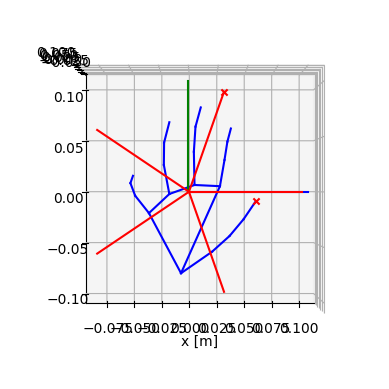

In [202]:
ax = plt.figure().add_subplot(projection='3d')
draw_hand(ax, world_landmarks, LINES_HAND, [end_effector_idx[0]], elev=90)
draw_starfish(ax, 0, [1])
plt.show()

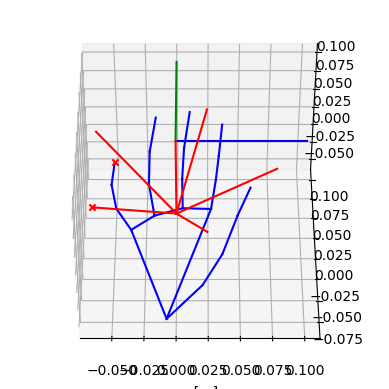

In [204]:
key_points = np.array([world_landmarks[:,0], -world_landmarks[:,1], -world_landmarks[:,2]])
h_ee = np.array([key_points[:,idx] / np.linalg.norm(key_points[:,idx]) for idx in h_ee_idx])

def cost_func(x, h_ee):
    cost = 0
    
    s_ee = starfish_ee(x)

    n = len(s_ee)
    m = len(h_ee)
    
    for i in range(n):
        ee_match = np.zeros(m)
        for j in range(m):
            ee_match[j] = np.dot(h_ee[j,0:2], s_ee[i,0:2]) # planar matching (h_ee is already normalized)

        best_match = np.argmax(ee_match)
        # print(f"{i} {best_match} {ee_match[best_match]} {s_ee[i]} {h_ee[best_match]}")
        if (ee_match[best_match] > 0.0):
            cost += (h_ee[best_match,2] - s_ee[i,2])**2
        
    return cost

sol = optimize.minimize(cost_func, [0, 0, 0, 0, 0], (h_ee))

ax = plt.figure().add_subplot(projection='3d')
draw_hand(ax, world_landmarks, LINES_HAND, h_ee_idx[4], elev=45)
draw_starfish(ax, sol.x[0], [3])
plt.show()

In [191]:
sol

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 8.2177084387649e-12
        x: [-6.750e-01 -6.086e-01 -8.342e-01 -8.342e-01 -6.750e-01]
      nit: 7
      jac: [-1.348e-06 -1.421e-06  2.323e-06  2.323e-06 -1.348e-06]
 hess_inv: [[ 9.115e-01  1.162e-03 ... -1.133e-02 -8.853e-02]
            [ 1.162e-03  7.434e-01 ... -1.053e-02  1.161e-03]
            ...
            [-1.133e-02 -1.053e-02 ...  1.074e+00 -1.133e-02]
            [-8.853e-02  1.161e-03 ... -1.133e-02  9.115e-01]]
     nfev: 48
     njev: 8